This notebook introduces time segmentation and smooth inference.

In [1]:
## General definitions

# rwa file
analysis_file = 'cropped_trajectories.rwa'

# webm file
movie = 'cropped_trajectories.webm'

# display settings
%matplotlib inline
import matplotlib.pyplot as plt
figsize = (12,9)

In [2]:
# load the analysis file

# in the case the required analysis file is missing, generate a minimal version of it again

# the previous notebook can also generate the file

import os.path
from tramway.helper import *

trajectory_file = 'transient_sinks.txt'
bounding_box = [0,0,2,2]

if os.path.exists(analysis_file):
    print("the '{}' file already exists".format(analysis_file))
    analyses = load_rwa(analysis_file)
else:
    trajectories = load_xyt(trajectory_file)
    cropped_trajectories = crop(trajectories, bounded_box)
    # we only need the root node (the trajectories) in the tree
    analyses = Analyses(cropped_trajectories)
    save_rwa(analysis_file, analyses)

the 'cropped_trajectories.rwa' file already exists


# Time segmentation

The `tessellate` helper supports time segment with a sliding window.

Related arguments are: `time_window_duration`, `time_window_shift` and `time_window_options`.

`time_window_duration` and `time_window_shift` are expressed in the same unit as
the `t` column of the trajectory dataframe, namely in seconds.

In [4]:
# choose a window duration
trajectories = analyses.data
total_duration = trajectories['t'].max() - trajectories['t'].min()
window_duration = total_duration / 6

# tessellate the space with a regular hexagonal mesh again,
# and then apply a sliding time window with no overlap
dynamic_segmentation_label = 'hexagonal mesh + sliding window'
tessellate(analyses, 'hexagon', output_label=dynamic_segmentation_label,
           time_window_duration=window_duration, # time segmentation
           avg_location_count=0, ref_distance=.12, # larger cells
           min_n=20)

window_duration

1.9166666666666672

The above notebook cell can be reproduced with the following shell command:

    tramway tessellate hexagon -i cropped_trajectories.rwa --time-window-duration 1.9166667 \
                               -l "hexagonal mesh + sliding window"

In [5]:
# the resulting time segments are available somewhere in the `analyses` object
cells = analyses[dynamic_segmentation_label].data
segments = cells.tessellation.time_lattice

# number of segments
nsegments = len(segments)

import pandas as pd
print('segments = ')
pd.DataFrame(segments, columns=['start', 'stop'])

segments = 


,start,stop
0,0.050000,1.966667
1,1.966667,3.883333
2,3.883333,5.800000
3,5.800000,7.716667
4,7.716667,9.633333
5,9.633333,11.550000


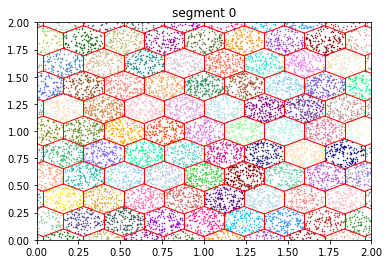

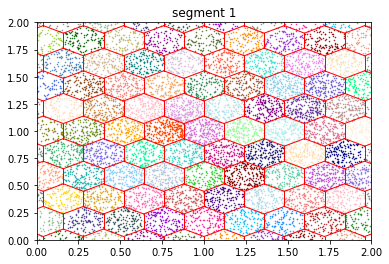

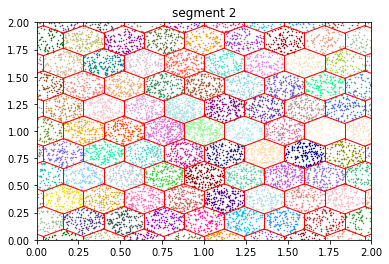

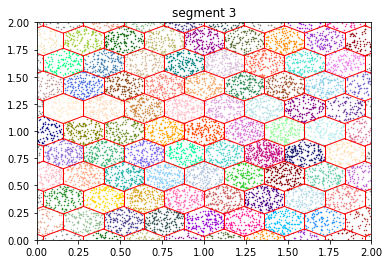

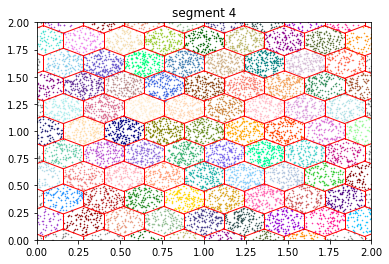

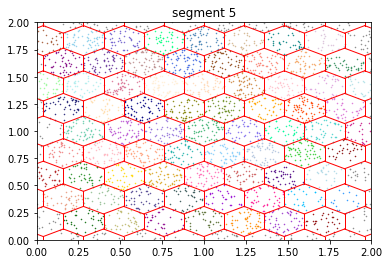

In [5]:
# plot the mesh and molecule locations for each segment

for segment in range(nsegments):
    cell_plot(cells, locations=dict(size=1), voronoi=dict(centroid_style=None),
              segment=segment, title='segment {}'.format(segment))

In [6]:
# let us infer DF without smoothing, just like in the previous notebook

import time
t0 = time.time()

infer(analyses, 'degraded.df', sigma=.01,
      input_label=dynamic_segmentation_label, output_label='degraded')

print('elapsed time: {:d}s'.format(round(time.time()-t0)))

elapsed time: 1s


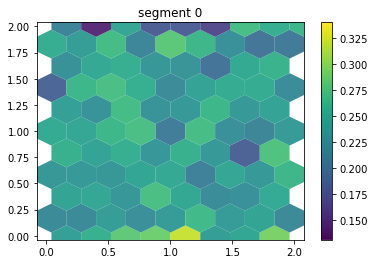

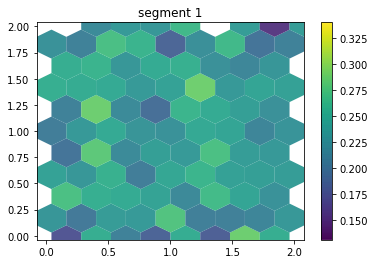

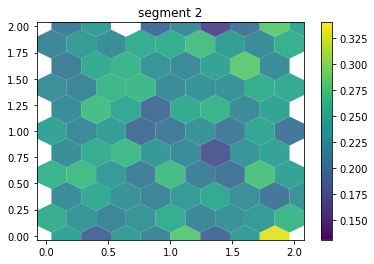

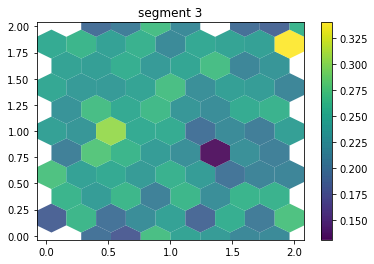

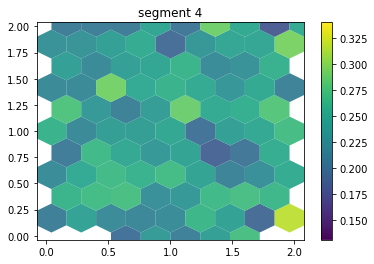

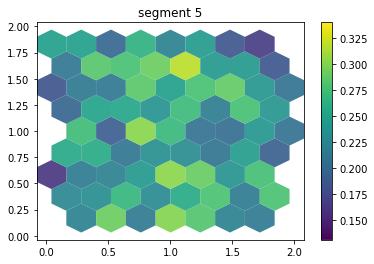

In [7]:
# and plot the non-smoothed maps

for segment in range(nsegments):
    
    map_plot(analyses, label=[dynamic_segmentation_label, 'degraded'], segment=segment,
            feature='diffusivity', title='segment {}'.format(segment))

# Smooth diffusivity

To regularize the diffusivity across space, we multiply the total posterior by a smoothing prior:

$$P^*(\textbf{D}, ... | T) = P_S(\textbf{D}) \prod_i P(D_i, ... | T_i)$$

$P_S$ is an improper prior that L2-regularize the spatial gradients $\nabla D$:

$$P_S(\textbf{D}) = \textrm{exp}\left(-\mu\sum_i ||\nabla D_i||^2\right)$$

$\mu$ is the smoothing parameter.

In [8]:
import time
t0 = time.time()

infer(analyses, 'standard.df', sigma=.01, tol=1e-5,
      input_label=dynamic_segmentation_label, output_label='DF mu=0',
      cell_sampling='connected',
      diffusivity_prior=0) # <= mu

print('elapsed time: {:d}s'.format(round(time.time()-t0)))

elapsed time: 15s


In [9]:
t0 = time.time()

infer(analyses, 'standard.df', sigma=.01, tol=1e-5,
      input_label=dynamic_segmentation_label, output_label='DF mu=100',
      cell_sampling='connected',
      diffusivity_prior=100) # <= mu

print('elapsed time: {:d}s'.format(round(time.time()-t0)))

elapsed time: 233s


The cell above can be reproduced with the following shell command:

    tramway infer standard.df -i cropped_trajectories.rwa --sigma .01 --tol 1e-5 \
                              -d 100 -L "hexagonal mesh + sliding window" -l "DF mu=100"

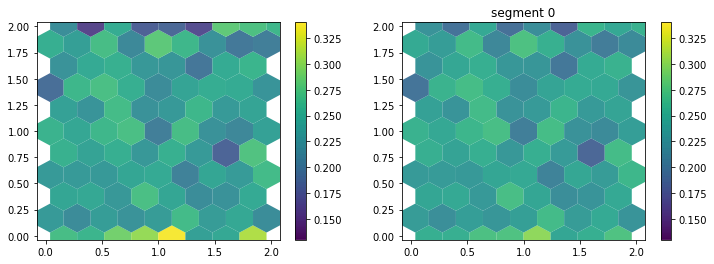

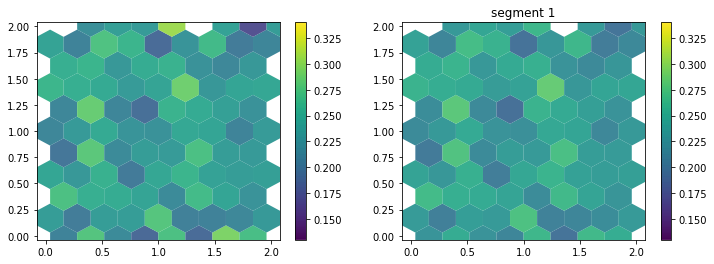

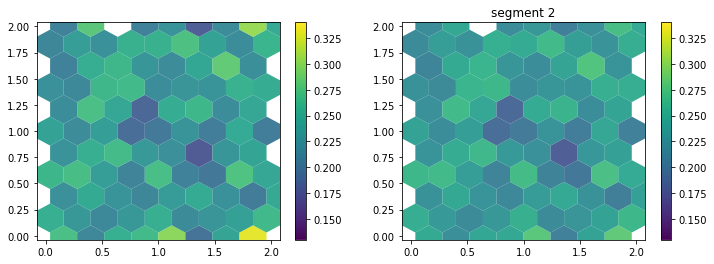

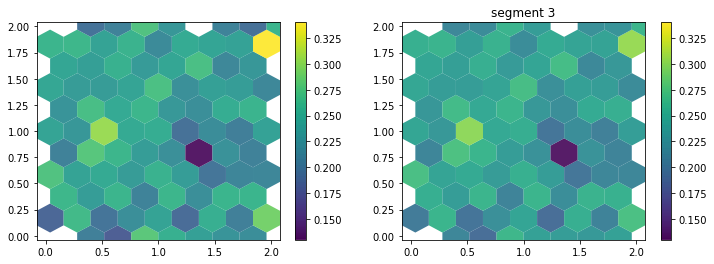

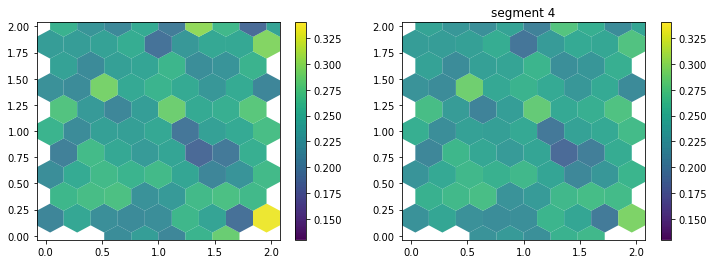

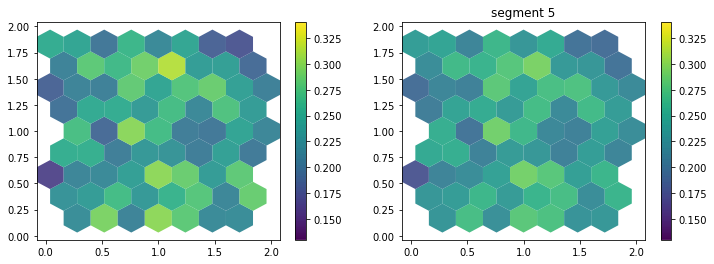

In [10]:
for segment in range(nsegments):
    
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    
    map_plot(analyses, label=[dynamic_segmentation_label, 'DF mu=0'], segment=segment,
             feature='diffusivity', title='segment {}'.format(segment),
             clim=[0.13, 0.34],
             figure=fig, axes=axes[0], show=False)
    map_plot(analyses, label=[dynamic_segmentation_label, 'DF mu=100'], segment=segment,
             feature='diffusivity', title='segment {}'.format(segment),
             clim=[0.13, 0.34],
             figure=fig, axes=axes[1], show=False)

plt.show()
# note: the colorbars are switched; fortunately they look all the same

The diffusivity looks indeed smoother, but what about the force?

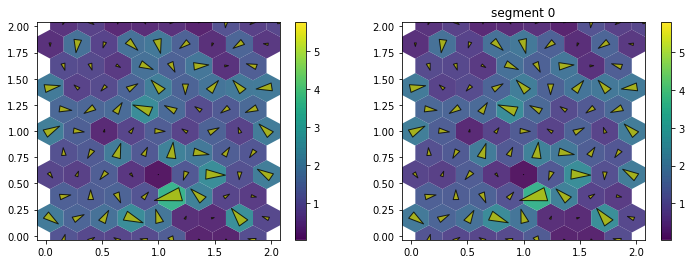

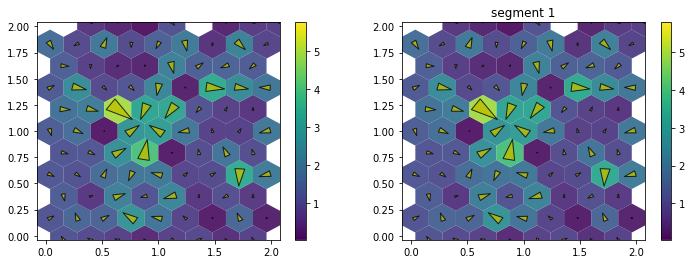

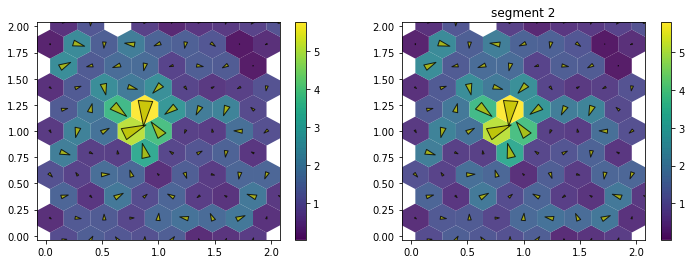

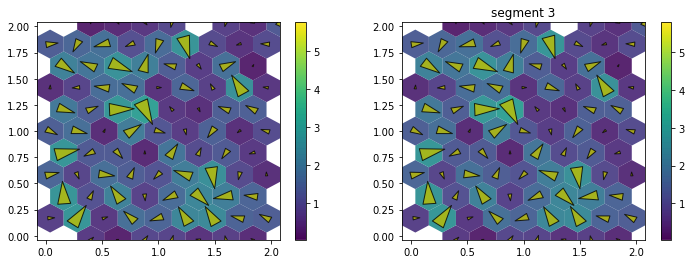

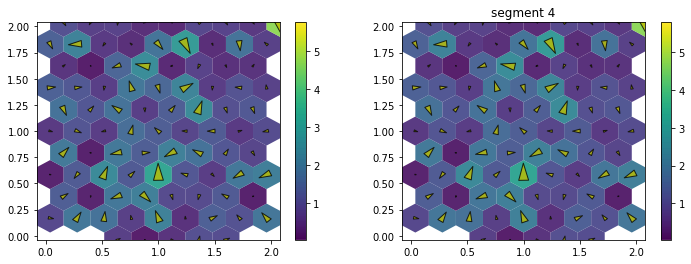

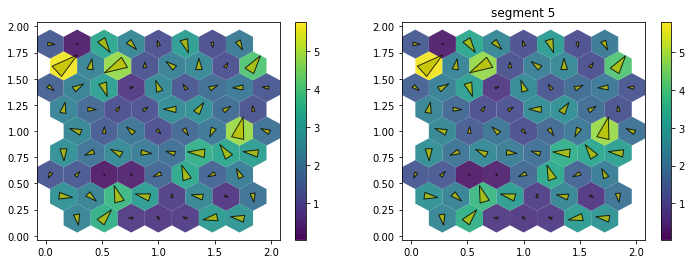

In [11]:
for segment in range(nsegments):
    
    fig, axes = plt.subplots(1,2)
    fig.set_size_inches(12, 4)
    
    map_plot(analyses, label=[dynamic_segmentation_label, 'DF mu=0'], segment=segment,
             feature='force', title='segment {}'.format(segment),
             cell_arrow_ratio=1,
             figure=fig, axes=axes[0], show=False)
    map_plot(analyses, label=[dynamic_segmentation_label, 'DF mu=100'], segment=segment,
             feature='force', title='segment {}'.format(segment),
             cell_arrow_ratio=1,
             figure=fig, axes=axes[1], show=False)

plt.show()

No difference...

Smoothing the force could be more advantageous.

# Smooth potential energy

The *DV* inference model additionally assumes $\textbf{F}(\textbf{r}) = - \nabla V(\textbf{r})$ where $V$ is a potential energy.

The maximized local posterior is:

$$P(D_i, V_i | T_i) \propto \prod_j \frac{\textrm{exp}\left(-\frac{\left(\Delta\textbf{r}_j + \frac{D_i\nabla V_i\Delta t_j}{k_BT}\right)^2}{4\left(D_i+\frac{\sigma^2}{\Delta t_j}\right)\Delta t_j}\right)}{4\pi\left(D_i+\frac{\sigma^2}{\Delta t_j}\right)\Delta t_j}$$

The vector force/drift is now explained by a scalar energy, hence reducing the number of parameters.

The potential energy landscape can be regularized just like the diffusivity, introducing a smoothing prior $P'_S$:

$$P^*(\textbf{D}, \textbf{V} | T) = P'_S(\textbf{V}) \prod_i P(D_i, V_i | T_i)$$

with:
$$P'_S(\textbf{V}) = \textrm{exp}\left(-\lambda\sum_i ||\nabla V_i||^2\right)$$

$\lambda$ is an additional smoothing parameter.

In [12]:
t0 = time.time()

infer(analyses, 'dv', sigma=.01, options=dict(ftol=1e-4),
      input_label=dynamic_segmentation_label, output_label='DV lambda=0',
      cell_sampling='connected',
      potential_prior=0) # <= lambda

print('elapsed time: {:d}s'.format(round(time.time()-t0)))

elapsed time: 464s


In [13]:
t0 = time.time()

infer(analyses, 'dv', sigma=.01, options=dict(ftol=1e-4),
      input_label=dynamic_segmentation_label, output_label='DV lambda=1',
      cell_sampling='connected',
      potential_prior=1) # <= lambda

print('elapsed time: {:d}s'.format(round(time.time()-t0)))

elapsed time: 394s


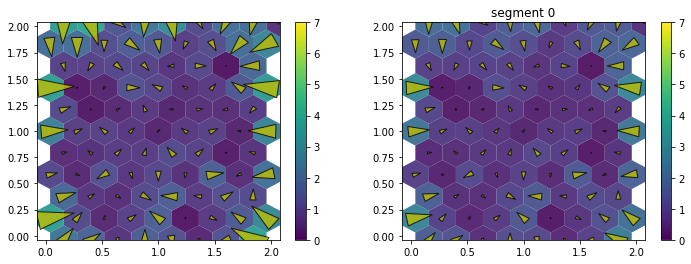

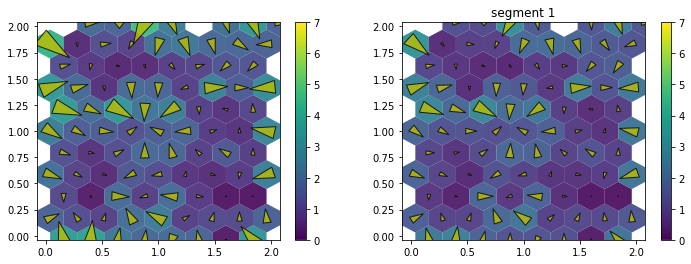

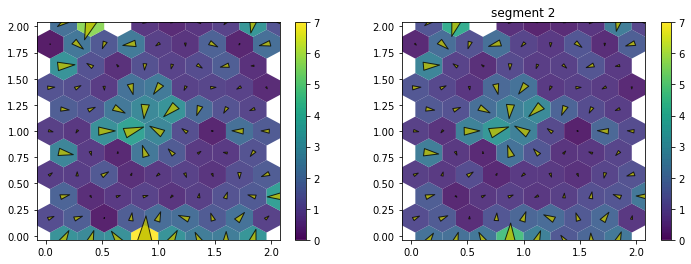

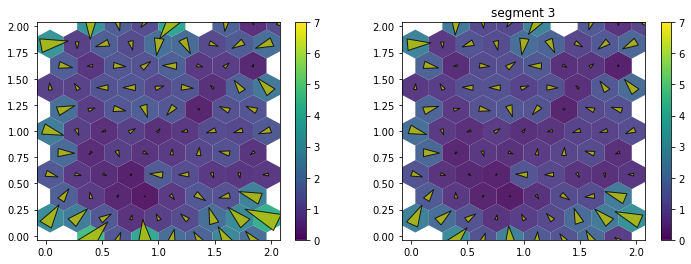

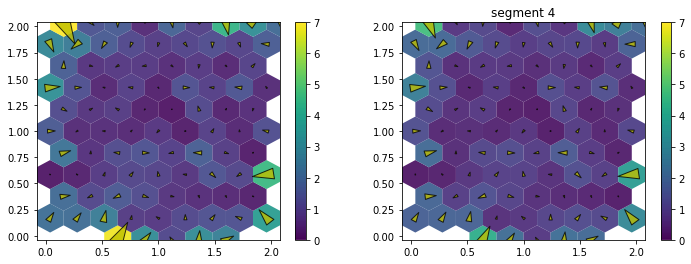

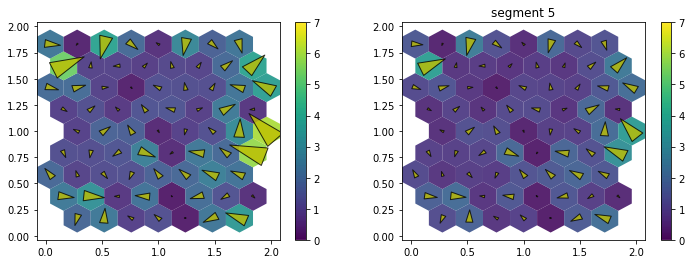

In [14]:
for segment in range(nsegments):
    
    fig, axes = plt.subplots(1,2)
    fig.set_size_inches(12, 4)
    
    map_plot(analyses, label=[dynamic_segmentation_label, 'DV lambda=0'], segment=segment,
             feature='force', title='segment {}'.format(segment),
             cell_arrow_ratio=.7, clim=[0,7],
             figure=fig, axes=axes[0], show=False)
    map_plot(analyses, label=[dynamic_segmentation_label, 'DV lambda=1'], segment=segment,
             feature='force', title='segment {}'.format(segment),
             cell_arrow_ratio=1, clim=[0,7],
             figure=fig, axes=axes[1], show=False)

plt.show()

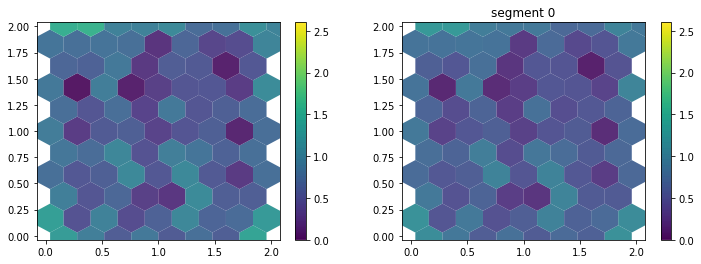

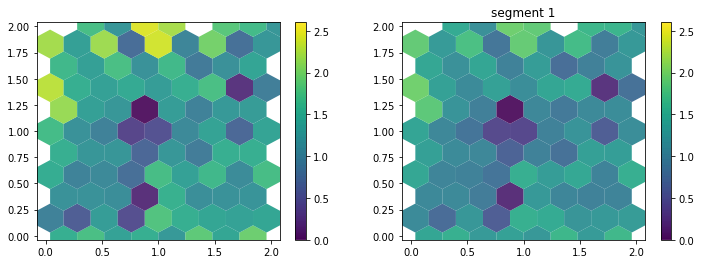

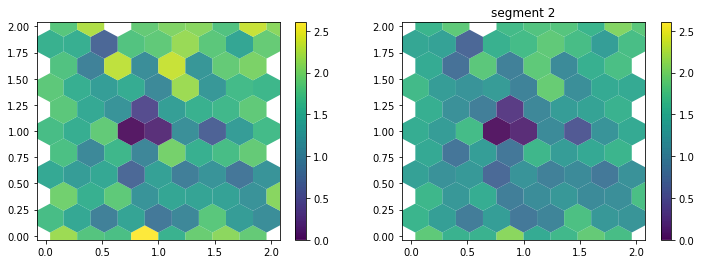

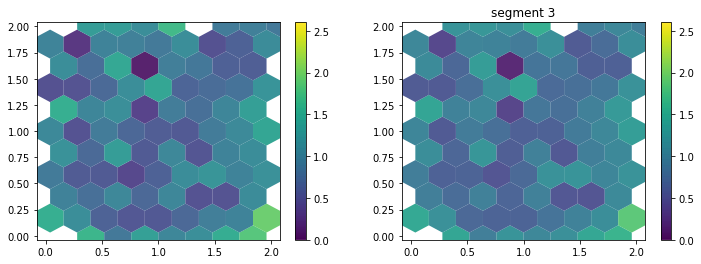

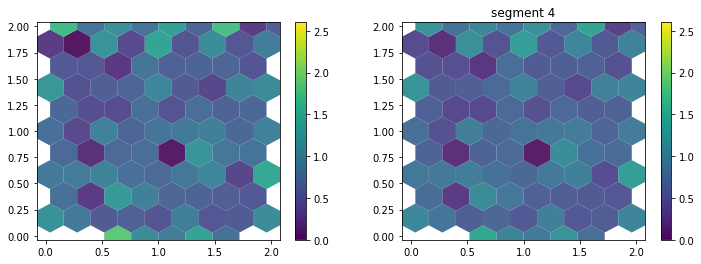

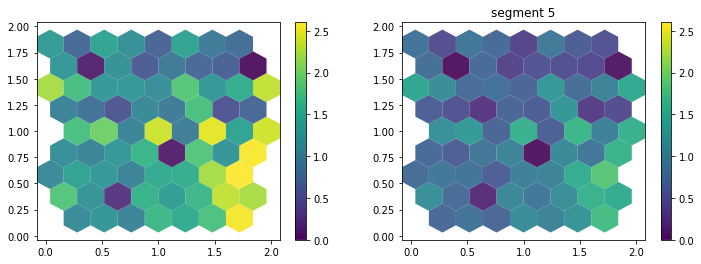

In [15]:
for segment in range(nsegments):
    
    fig, axes = plt.subplots(1,2)
    fig.set_size_inches(12, 4)
    
    map_plot(analyses, label=[dynamic_segmentation_label, 'DV lambda=0'], segment=segment,
             feature='potential', title='segment {}'.format(segment),
             clim=[0, 2.6],
             figure=fig, axes=axes[0], show=False)
    map_plot(analyses, label=[dynamic_segmentation_label, 'DV lambda=1'], segment=segment,
             feature='potential', title='segment {}'.format(segment),
             clim=[0, 2.6],
             figure=fig, axes=axes[1], show=False)

plt.show()

In [16]:
# save
save_rwa(analysis_file, analyses, force=True)

# Temporal smoothing

We introduce yet another smoothing prior:

$$P''_S(\textbf{D},\textbf{V}) = \textrm{exp}\left(-\tau\left(\mu\sum_i \frac{\partial D_i}{\partial t}^2 + \lambda\sum_i \frac{\partial V_i}{\partial t}^2\right)\right)$$

The parameters for the different segments must be inferred all at once, which becomes intractable.

The *stochastic.dv* mode randomly pick and choose a cell at each iteration and perform a gradient descent step
on the associated parameters considering the neighbour cells instead of the full tessellation.

We first need to build the tessellation so that the temporally-replicated cells are connected between successive segments.
This is required by the time regularization.

In [14]:
segmentation_label = 'time-regularizable hexagonal mesh'
tessellate(analyses, 'hexagon', output_label=segmentation_label,
           time_window_duration=window_duration,
           enable_time_regularization=True, # <= here is the difference
           avg_location_count=0, ref_distance=.12,
           min_n=20)

In [15]:
print('you can interrupt the kernel (or hit Ctrl+C if not in a notebook) to stop the inference before convergence; maps will be generated anyway')
infer(analyses, 'stochastic.dv',
      input_label=segmentation_label, output_label='sDV lambda=1 tau=10',
      potential_prior=1.,
      time_prior=.1, # <= tau
      sigma=.01)

you can interrupt the kernel (or hit Ctrl+C if not in a notebook) to stop the inference before convergence; maps will be generated anyway


/home/francois/github/TRamWAy/tramway/inference/stochastic_dv.py:205: RuntimeWarning: time_derivative(311, V) failed
  warn('time_derivative({}, V) failed'.format(i), RuntimeWarning)
/home/francois/github/TRamWAy/tramway/inference/stochastic_dv.py:205: RuntimeWarning: time_derivative(96, V) failed
  warn('time_derivative({}, V) failed'.format(i), RuntimeWarning)
/home/francois/github/TRamWAy/tramway/inference/stochastic_dv.py:205: RuntimeWarning: time_derivative(516, V) failed
  warn('time_derivative({}, V) failed'.format(i), RuntimeWarning)
/home/francois/github/TRamWAy/tramway/inference/stochastic_dv.py:205: RuntimeWarning: time_derivative(238, V) failed
  warn('time_derivative({}, V) failed'.format(i), RuntimeWarning)
/home/francois/github/TRamWAy/tramway/inference/stochastic_dv.py:205: RuntimeWarning: time_derivative(101, V) failed
  warn('time_derivative({}, V) failed'.format(i), RuntimeWarning)
/home/francois/github/TRamWAy/tramway/inference/stochastic_dv.py:205: RuntimeWarning: 

# Movie output

In [4]:
from tramway.helper.animation import *
from matplotlib.transforms import Bbox

animate_map_2d_helper(analyses, movie, label=[segmentation_label, 'sDV lambda=1 tau=10'],
                      feature='force', codec='libvpx-vp9')


overwrite file 'cropped_trajectories.webm': [N/y] y


100%|██████████| 6/6 [00:00<00:00,  7.57it/s]


In [5]:
from IPython.display import HTML

HTML('''
<video width="640" height="480" controls>
  <source src="{}" type="video/webm">
</video>
'''.format(movie))

In [27]:
print(analyses)

<class 'pandas.core.frame.DataFrame'>
	'hexagonal mesh' <class 'tramway.tessellation.base.CellStats'>
		'diffusivity and force' <class 'tramway.inference.base.Maps'>
		'diffusivity and noisy force' <class 'tramway.inference.base.Maps'>
	'hexagonal mesh + sliding window' <class 'tramway.tessellation.base.CellStats'>
		'degraded' <class 'tramway.inference.base.Maps'>
		'DF mu=0' <class 'tramway.inference.base.Maps'>
		'DF mu=100' <class 'tramway.inference.base.Maps'>
		'DV lambda=0' <class 'tramway.inference.base.Maps'>
		'DV lambda=1' <class 'tramway.inference.base.Maps'>
